<a href="https://colab.research.google.com/github/kscale/QuickLearn/blob/master/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn


In [3]:
# device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1.get data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## show an image



Random image path: data/pizza_steak_sushi/train/pizza/618348.jpg
Image class: pizza
Image height: 512
Image width: 512


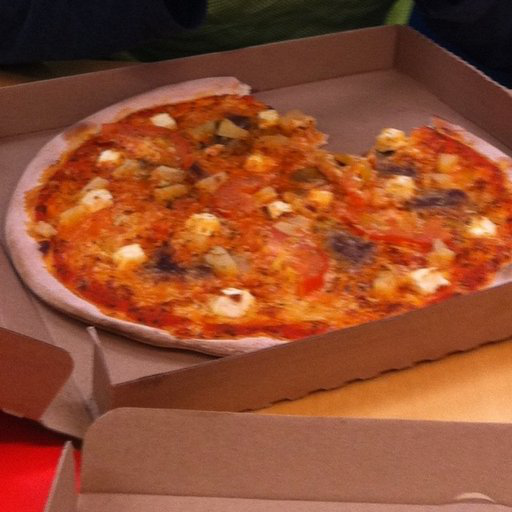

In [6]:
import random
from PIL import Image

#random.seed(42)
#1.随机得到一张图片的地址
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
#2.open
img = Image.open(random_image_path)
#3.Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

#2.transforming data

In [7]:
import random
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

1. 需要把images转化成tensor  `torchvision.transforms`
2. data augmentation

In [9]:
# write transform for image
data_transform = transforms.Compose([
    #1.resize
    transforms.Resize(size=(64,64)),
    #flip
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch.Tensor
    transforms.ToTensor()
])

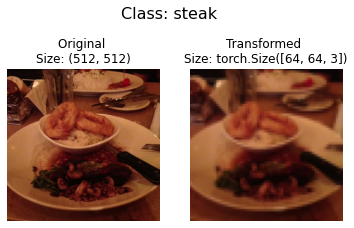

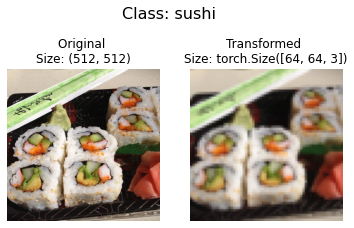

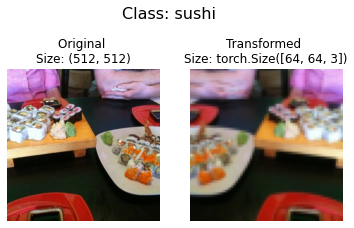

In [10]:
from torch.utils.data.dataset import random_split
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  """Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
      image_paths (list): List of target image paths. 
      transform (PyTorch Transforms): Transforms to apply to images.
      n (int, optional): Number of images to plot. Defaults to 3.
      seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random.seed(42)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
            transform=data_transform, 
            n=3)

#3.create datasets

##3.2方法一 loading image data using ImageFolder 

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                  transform=data_transform,
                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                  transform=data_transform,)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
len(train_data)

225

检查一下datasets中的内容

In [13]:
# 检查一下datasets中的内容
class_names = train_data
class_names

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

## data loader

In [16]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                batch_size=1,
                num_workers=1,
                shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                batch_size=1,
                num_workers=1,
                shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f2ddc576700>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2ddc576790>)

In [17]:
img,label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


##3.2方法二 loading image data with a custom `dataset`

In [18]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

 using `os.scandir()` to traverse a target directory

In [19]:
# setup path for target directory
target_directory = train_dir
print(f"{target_directory=}")

# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

target_directory=PosixPath('data/pizza_steak_sushi/train')
Class names found: ['pizza', 'steak', 'sushi']


In [20]:
[i.name for i in os.scandir(image_path / "train")]

['sushi', 'pizza', 'steak']

写一个函数寻找路径上的类名

In [21]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [22]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [23]:
print(dir(train_data))

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_format_transform_repr', '_is_protocol', '_repr_indent', 'class_to_idx', 'classes', 'extensions', 'extra_repr', 'find_classes', 'imgs', 'loader', 'make_dataset', 'root', 'samples', 'target_transform', 'targets', 'transform', 'transforms']


In [24]:
print(hasattr(train_data,'samples'))


True


##write a custom dataset class

In [25]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
#use custom dataset class turn dataset
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                    transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                    transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f2df63f0cd0>,
 <__main__.ImageFolderCustom at 0x7f2ddc55c9d0>)

In [28]:
# do some test
len(train_data_custom)

225

In [29]:
train_data_custom.classes


['pizza', 'steak', 'sushi']

In [30]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


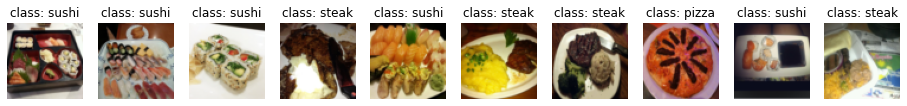

In [31]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
            n=12, 
            classes=train_data_custom.classes,
            seed=None) # Try setting the seed for reproducible images

## turn custom loaded images into dataloader

In [32]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                    batch_size=1,
                    num_workers=0,
                    shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                   batch_size=1,
                   num_workers=0,
                   shuffle=False)

train_dataloader_custom, test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x7f2ddba8aee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2ddba8ad60>)

In [33]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


##另一种数据增强的方式

In [34]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

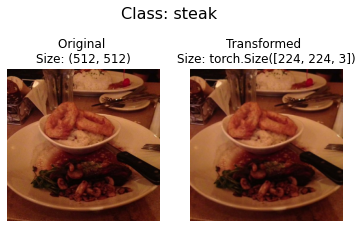

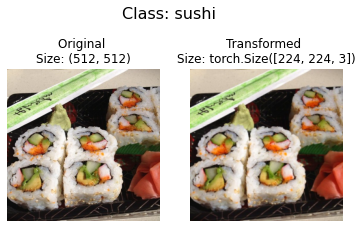

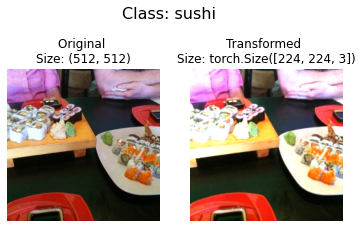

In [35]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

#4.Model0
TinyVGG　without data augmentation

1.确定transform-->2.load datasets---->3.turn data into dataloader

In [36]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [37]:
# ## 1.对数据转换
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f2ddb90d790>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2ddb90d670>)

In [38]:
## 2.create a model
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from: 
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                  stride=2) # default stride value is same as kernel_size
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*16*16,    #通过测试修改这里的数值
                out_features=output_shape)
      )
  def forward(self,x:torch.Tensor):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)   #这里的数值传到了classifier的in_features中
    x = self.classifier(x)
    #print(x.shape)
    return x
  

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
          hidden_units=10,
          output_shape=len(train_data.classes)).to(device)

model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

##4.1 try a forward pass on a single image 
to test the model

In [39]:
image_batch,label_batch = next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [40]:
# try a forward pass
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0352],
        [0.0658, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0375],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0348],
        [0.0620, 0.0599, 0.0370],
        [0.0607, 0.0628, 0.0387],
        [0.0637, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0690, 0.0330],
        [0.0557, 0.0570, 0.0357],
        [0.0631, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0369],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0638, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

##4.2 use `torchinfo`

In [41]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[32, 3, 64, 64]) # do a test pass through of an example input size 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

##4.3 write train and test function

In [42]:
def train_step(model:torch.nn.Module,
        dataloader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        optimizer:torch.optim.Optimizer):
  # put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # loop through data loader and batches
  for batch,(X,y) in enumerate(dataloader):
    # send data to target device
    X,y = X.to(device),y.to(device)

    # 1. forward pass
    y_pred = model(X)
    #
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3.optimizer zero grad
    optimizer.zero_grad()

    # 4.loss backward
    loss.backward()

    # 5.optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 

  return train_loss, train_acc


In [43]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [44]:
# create a train() function 
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
      train_dataloader:torch.utils.data.DataLoader,
      test_dataloader:torch.utils.data.DataLoader,
      optimizer:torch.optim.Optimizer,
      loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
      epochs:int = 5):
  
  # create empty results dictionary
  results = {"train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]}
  
  # 3.loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model=model,
                      dataloader=train_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer)
    test_loss,test_acc = test_step(model=model,
                    dataloader=test_dataloader,
                    loss_fn=loss_fn)
    # print out
    print(
        f"Epoch:{epoch+1} | "
        f"train_loss:{train_loss:.4f} |"
        f"train_acc:{train_acc:.4f} |"
        f"test_loss:{test_loss:.4f} |"
        f"test_acc:{test_acc:.4f}"
    )

    #update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

##4.4 train and evaluate

In [45]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

# a model instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
          hidden_units=10,
          output_shape=len(train_data.classes)).to(device)

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.1)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train 
model_0_results = train(model=model_0, 
            train_dataloader=train_dataloader_simple,
            test_dataloader=test_dataloader_simple,
            optimizer=optimizer,
            loss_fn=loss_fn, 
            epochs=NUM_EPOCHS)


# close the timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | train_loss:91.5897 |train_acc:0.3828 |test_loss:1.1434 |test_acc:0.1979
Epoch:2 | train_loss:1.2604 |train_acc:0.2695 |test_loss:1.1465 |test_acc:0.2604
Epoch:3 | train_loss:1.0901 |train_acc:0.4258 |test_loss:1.1523 |test_acc:0.2604
Epoch:4 | train_loss:1.1031 |train_acc:0.3047 |test_loss:1.1453 |test_acc:0.2604
Epoch:5 | train_loss:1.1008 |train_acc:0.2734 |test_loss:1.1556 |test_acc:0.1979
Total training time: 7.745 seconds


##4.5how to improve model quality


In [46]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [47]:
def plot_loss_curves(results:Dict[str,List[float]]):
  """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
  """
  # get the loss values of the results dictionary(training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # get the accuracy values of the results dictionary
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # setup a plot
  plt.figure(figsize=(15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

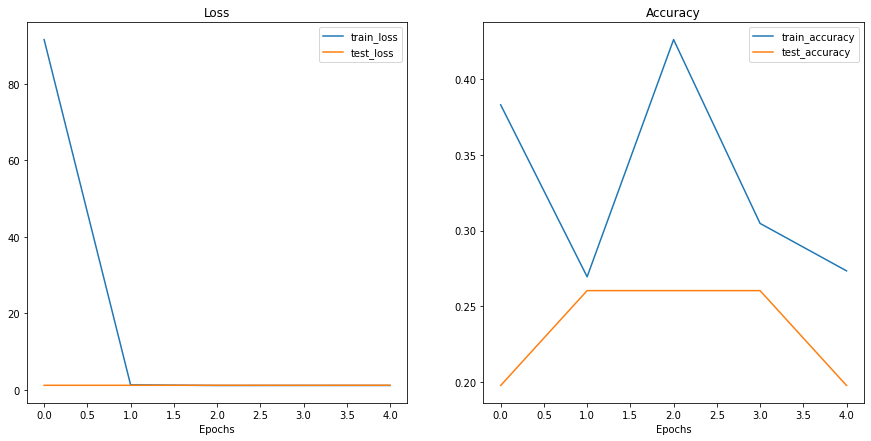

In [48]:
plot_loss_curves(model_0_results)

#5.Model1 -- TinyVGG with data augmentation

In [49]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [50]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [51]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f2dda6dd430>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2ddc576790>)

In [52]:
# create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [53]:
# begin to train
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5


# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.1)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train 
model_1_results = train(model=model_1, 
            train_dataloader=train_dataloader_simple,
            test_dataloader=test_dataloader_simple,
            optimizer=optimizer,
            loss_fn=loss_fn, 
            epochs=NUM_EPOCHS)


# close the timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | train_loss:1.0976 |train_acc:0.2617 |test_loss:1.1037 |test_acc:0.2083
Epoch:2 | train_loss:1.0975 |train_acc:0.2617 |test_loss:1.1037 |test_acc:0.2083
Epoch:3 | train_loss:1.0972 |train_acc:0.3828 |test_loss:1.1037 |test_acc:0.2083
Epoch:4 | train_loss:1.0975 |train_acc:0.2617 |test_loss:1.1037 |test_acc:0.2083
Epoch:5 | train_loss:1.0973 |train_acc:0.3828 |test_loss:1.1037 |test_acc:0.2083
Total training time: 7.535 seconds


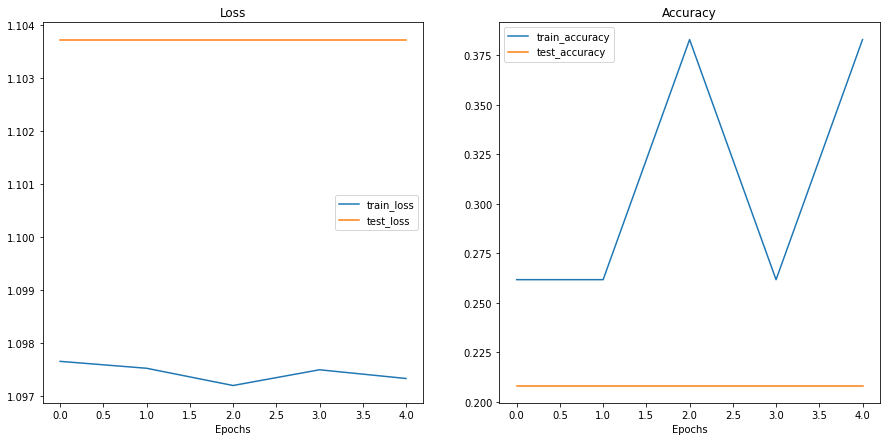

In [54]:
plot_loss_curves(model_1_results)

In [55]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,91.589743,0.382812,1.143358,0.197917
1,1.260428,0.269531,1.146461,0.260417
2,1.090141,0.425781,1.152343,0.260417
3,1.103077,0.304688,1.145331,0.260417
4,1.100789,0.273438,1.155570,0.197917


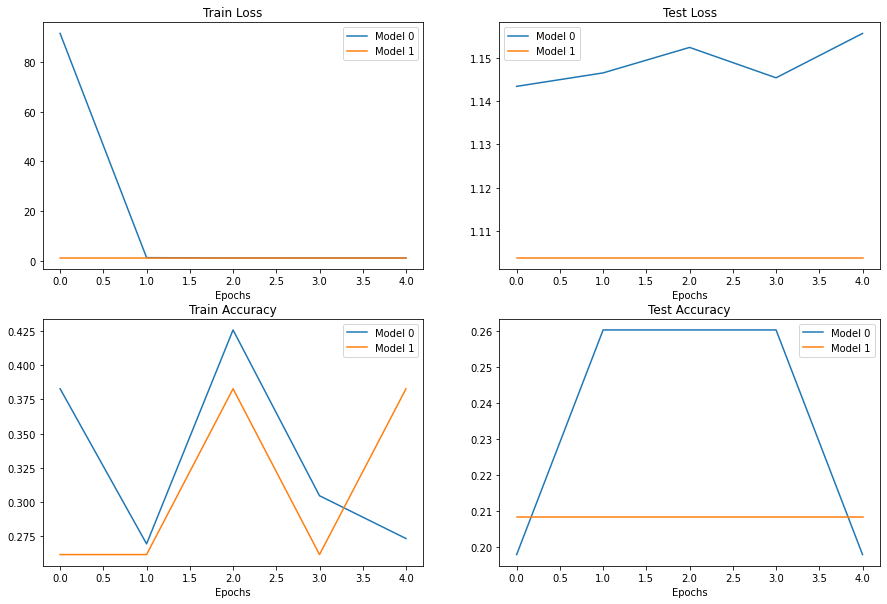

In [56]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

#6.make a prediction on a custom image

In [57]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [62]:
import torchvision

# read in custom image
#custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
# Print out image data
#print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dtype: torch.float32


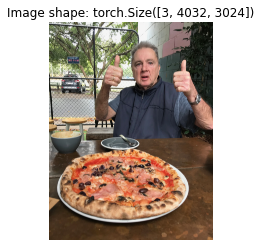

In [64]:
# Plot custom image
plt.imshow((custom_image/255).permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [68]:
# 图片太大, reshape ,should be the same size as the model

# 1.define the transform to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64)),
])

# 2.transform the custom image
custom_image_transformed = custom_image_transform(custom_image)


# 3.评估
model_1.eval()
with torch.inference_mode():
    # 4. Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


tensor([[5.1296, 4.2111, 0.0301]], device='cuda:0')

In [69]:
print(f"Prediction logits:{custom_image_pred}")

Prediction logits:tensor([[5.1296, 4.2111, 0.0301]], device='cuda:0')


using torch.softmax() for multi-class classification

In [73]:
#using torch.softmax() for multi-class classification
custom_image_pred_probs = torch.softmax(custom_image_pred,dim=1)
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction label: tensor([0], device='cuda:0')


In [85]:
class_names =class_names_found

In [86]:
class_names[custom_image_pred_label.cpu()]

'pizza'

##6.1 build a function to predict custom images


In [83]:

def pred_and_plot_image(model:torch.nn.Module,
            image_path:str,
            class_names:List[str]=None,
            transform=None,
            device:torch.device=device):
  """ Makes a prediction on a target image and plots the image with its prediction."""

  #1. load in image and convert the tensor values to float32 
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel values by 255 to get them between [0,1]
  target_image =target_image/255.

  # 3. Transform if necessary
  if transform:
    target_image = transform(target_image)


  # 4. make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference model
  model.eval()
  with torch.inference_mode():
    # add an extra dimension to the image
    target_image = target_image.unsqueeze(dim=0)
    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(target_image.to(device))
  
  # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # make a prediction :probabilities ---> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

  # 8. plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib)
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else: 
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);




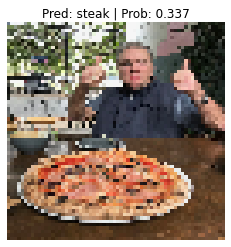

In [87]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)